In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:

#Load dataset
def load_dataset(path=r'yahoo_stock.csv'):
  return pd.read_csv(path)

In [3]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [4]:
def prepare_data(df):
  df_aux = df.drop(columns=['High', 'Low', 'Volume', 'Adj Close'], inplace=False)
  df_aux = df_aux.set_index('Date')
  return df_aux

In [5]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['Open']] = scaler.fit_transform(df[['Open']])
  df[['Close']] = scaler.fit_transform(df[['Close']])
  return scaler

In [6]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [7]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [8]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [9]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [10]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
  #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'yahoo_model.png', show_shapes=True)
  return model

In [11]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [12]:
#Main Execution
#the dataframes
df_raw = load_dataset()
#Get data from 2015 to the end of 2018
df_raw = df_raw[:1134]
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [13]:
#load modelo forecast close
model_close = tf.keras.models.load_model('modelo_aux_close_9.h5', custom_objects={'rmse': rmse})# Show the model architecture
model_close.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 10, 64)            17152     
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 130       
Total params: 31,810
Trainable params: 31,810
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito do Open normalizado
    yhat_aux = model_close.predict(inp)  #dá o valor predito do Close normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[[yhat[0][0],yhat_aux[0][0]]],axis=0)
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  return forecasts



In [15]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data['Open'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Yahoo stock price')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [16]:
tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

}
# record da history de cada modelo
record = {}

In [17]:
n_variate = 2

Epoch 1/10
51/51 [==============================] - 5s 31ms/step - loss: 0.3345 - mae: 0.3232 - rmse: 0.3345 - val_loss: 0.0128 - val_mae: 0.0109 - val_rmse: 0.0125
Epoch 2/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1389 - mae: 0.1243 - rmse: 0.1388 - val_loss: 0.0171 - val_mae: 0.0143 - val_rmse: 0.0172
Epoch 3/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1596 - mae: 0.1480 - rmse: 0.1596 - val_loss: 0.0902 - val_mae: 0.0901 - val_rmse: 0.0905
Epoch 4/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1299 - mae: 0.1172 - rmse: 0.1299 - val_loss: 0.0799 - val_mae: 0.0788 - val_rmse: 0.0802
Epoch 5/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1338 - mae: 0.1227 - rmse: 0.1338 - val_loss: 0.0564 - val_mae: 0.0554 - val_rmse: 0.0567

Epoch 00005: val_loss improved from inf to 0.05641, saving model to my_model_5_0.056.h5
Epoch 6/10
51/51 [==============================] - 0s 9ms/step - loss: 0.1588 - mae: 0.15

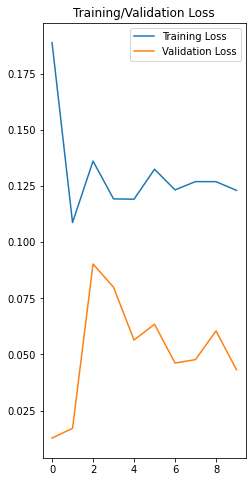

Epoch 1/10
102/102 [==============================] - 1s 9ms/step - loss: 0.1043 - mae: 0.0973 - rmse: 0.1041 - val_loss: 0.0322 - val_mae: 0.0295 - val_rmse: 0.0324
Epoch 2/10
102/102 [==============================] - 1s 8ms/step - loss: 0.1262 - mae: 0.1195 - rmse: 0.1257 - val_loss: 0.0396 - val_mae: 0.0374 - val_rmse: 0.0399
Epoch 3/10
102/102 [==============================] - 1s 8ms/step - loss: 0.1050 - mae: 0.0989 - rmse: 0.1046 - val_loss: 0.0497 - val_mae: 0.0475 - val_rmse: 0.0500
Epoch 4/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0949 - mae: 0.0882 - rmse: 0.0946 - val_loss: 0.0256 - val_mae: 0.0242 - val_rmse: 0.0255
Epoch 5/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0873 - mae: 0.0804 - rmse: 0.0869 - val_loss: 0.0489 - val_mae: 0.0468 - val_rmse: 0.0493

Epoch 00005: val_loss did not improve from 0.04317
Epoch 6/10
102/102 [==============================] - 1s 8ms/step - loss: 0.0857 - mae: 0.0792 - rmse: 0.0853 - val_lo

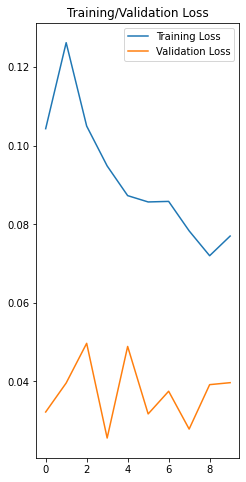

Epoch 1/10
152/152 [==============================] - 3s 7ms/step - loss: 0.0652 - mae: 0.0583 - rmse: 0.0652 - val_loss: 0.0688 - val_mae: 0.0627 - val_rmse: 0.0688
Epoch 2/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0573 - mae: 0.0502 - rmse: 0.0573 - val_loss: 0.0601 - val_mae: 0.0502 - val_rmse: 0.0606
Epoch 3/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0414 - mae: 0.0347 - rmse: 0.0414 - val_loss: 0.0530 - val_mae: 0.0466 - val_rmse: 0.0537
Epoch 4/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0436 - mae: 0.0366 - rmse: 0.0436 - val_loss: 0.0498 - val_mae: 0.0433 - val_rmse: 0.0505
Epoch 5/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0438 - mae: 0.0379 - rmse: 0.0438 - val_loss: 0.0485 - val_mae: 0.0417 - val_rmse: 0.0491

Epoch 00005: val_loss did not improve from 0.03969
Epoch 6/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0507 - mae: 0.0450 - rmse: 0.0507 - val_lo

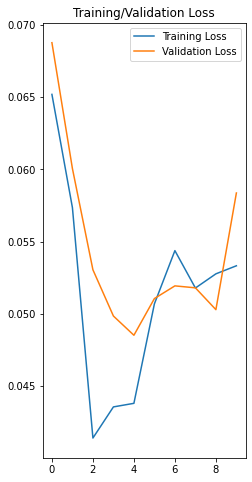

[array([[2511.6228, 2511.6396]], dtype=float32), array([[2518.062 , 2518.1455]], dtype=float32), array([[2523.278, 2523.464]], dtype=float32), array([[2527.578 , 2528.1853]], dtype=float32), array([[2530.6313, 2531.5269]], dtype=float32), array([[2533.1372, 2534.1978]], dtype=float32), array([[2535.799, 2537.02 ]], dtype=float32), array([[2538.5063, 2539.8733]], dtype=float32), array([[2541.0273, 2542.48  ]], dtype=float32), array([[2543.4717, 2544.9907]], dtype=float32), array([[2545.822 , 2547.3958]], dtype=float32), array([[2548.0737, 2549.6965]], dtype=float32), array([[2550.2366, 2551.9062]], dtype=float32), array([[2552.3171, 2554.0334]], dtype=float32), array([[2554.3167, 2556.0771]], dtype=float32)]
[2511.6228, 2518.062, 2523.278, 2527.578, 2530.6313, 2533.1372, 2535.799, 2538.5063, 2541.0273, 2543.4717, 2545.822, 2548.0737, 2550.2366, 2552.3171, 2554.3167]


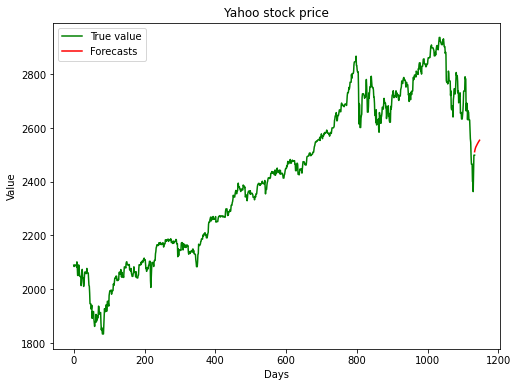

Epoch 1/50
51/51 [==============================] - 4s 25ms/step - loss: 0.3421 - mae: 0.3321 - rmse: 0.3420 - val_loss: 0.0386 - val_mae: 0.0348 - val_rmse: 0.0387
Epoch 2/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1372 - mae: 0.1210 - rmse: 0.1372 - val_loss: 0.0124 - val_mae: 0.0103 - val_rmse: 0.0126
Epoch 3/50
51/51 [==============================] - 0s 10ms/step - loss: 0.1703 - mae: 0.1589 - rmse: 0.1703 - val_loss: 0.0756 - val_mae: 0.0737 - val_rmse: 0.0759
Epoch 4/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1286 - mae: 0.1148 - rmse: 0.1286 - val_loss: 0.0871 - val_mae: 0.0868 - val_rmse: 0.0874
Epoch 5/50
51/51 [==============================] - 0s 9ms/step - loss: 0.1257 - mae: 0.1145 - rmse: 0.1257 - val_loss: 0.0642 - val_mae: 0.0630 - val_rmse: 0.0645

Epoch 00005: val_loss improved from inf to 0.06423, saving model to my_model_5_0.064.h5
Epoch 6/50
51/51 [==============================] - 0s 10ms/step - loss: 0.1434 - mae: 0.

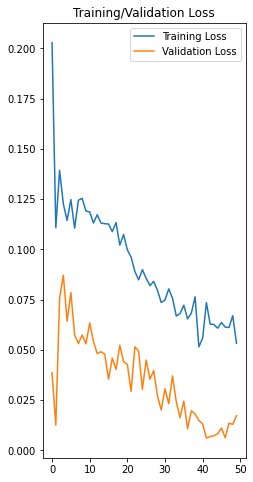

Epoch 1/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0384 - mae: 0.0334 - rmse: 0.0382 - val_loss: 0.0310 - val_mae: 0.0288 - val_rmse: 0.0331
Epoch 2/50
102/102 [==============================] - 1s 8ms/step - loss: 0.0430 - mae: 0.0374 - rmse: 0.0428 - val_loss: 0.0274 - val_mae: 0.0255 - val_rmse: 0.0291
Epoch 3/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0500 - mae: 0.0453 - rmse: 0.0499 - val_loss: 0.0276 - val_mae: 0.0258 - val_rmse: 0.0293
Epoch 4/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0433 - mae: 0.0389 - rmse: 0.0432 - val_loss: 0.0142 - val_mae: 0.0117 - val_rmse: 0.0155
Epoch 5/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0423 - mae: 0.0374 - rmse: 0.0422 - val_loss: 0.0194 - val_mae: 0.0170 - val_rmse: 0.0212

Epoch 00005: val_loss did not improve from 0.00824
Epoch 6/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0480 - mae: 0.0437 - rmse: 0.0479 - val_lo

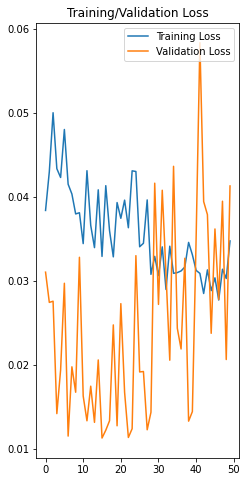

Epoch 1/50
152/152 [==============================] - 3s 8ms/step - loss: 0.0336 - mae: 0.0284 - rmse: 0.0336 - val_loss: 0.0796 - val_mae: 0.0753 - val_rmse: 0.0800
Epoch 2/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0379 - mae: 0.0330 - rmse: 0.0379 - val_loss: 0.0377 - val_mae: 0.0331 - val_rmse: 0.0380
Epoch 3/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0392 - mae: 0.0339 - rmse: 0.0392 - val_loss: 0.0326 - val_mae: 0.0283 - val_rmse: 0.0327
Epoch 4/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0397 - mae: 0.0349 - rmse: 0.0397 - val_loss: 0.0322 - val_mae: 0.0279 - val_rmse: 0.0322
Epoch 5/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0375 - mae: 0.0324 - rmse: 0.0375 - val_loss: 0.0649 - val_mae: 0.0598 - val_rmse: 0.0653

Epoch 00005: val_loss did not improve from 0.00824
Epoch 6/50
152/152 [==============================] - 1s 7ms/step - loss: 0.0327 - mae: 0.0280 - rmse: 0.0327 - val_lo

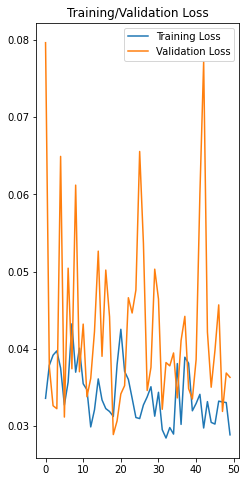

[array([[2482.8933, 2482.8325]], dtype=float32), array([[2477.6934, 2477.5464]], dtype=float32), array([[2476.4553, 2476.278 ]], dtype=float32), array([[2473.3599, 2473.1685]], dtype=float32), array([[2469.4114, 2469.2185]], dtype=float32), array([[2465.2336, 2465.0435]], dtype=float32), array([[2460.922 , 2460.7354]], dtype=float32), array([[2456.5464, 2456.362 ]], dtype=float32), array([[2452.3696, 2452.1868]], dtype=float32), array([[2448.4302, 2448.2495]], dtype=float32), array([[2444.6934, 2444.5151]], dtype=float32), array([[2441.123, 2440.948]], dtype=float32), array([[2437.701 , 2437.5286]], dtype=float32), array([[2434.419 , 2434.2495]], dtype=float32), array([[2431.273 , 2431.1067]], dtype=float32)]
[2482.8933, 2477.6934, 2476.4553, 2473.3599, 2469.4114, 2465.2336, 2460.922, 2456.5464, 2452.3696, 2448.4302, 2444.6934, 2441.123, 2437.701, 2434.419, 2431.273]


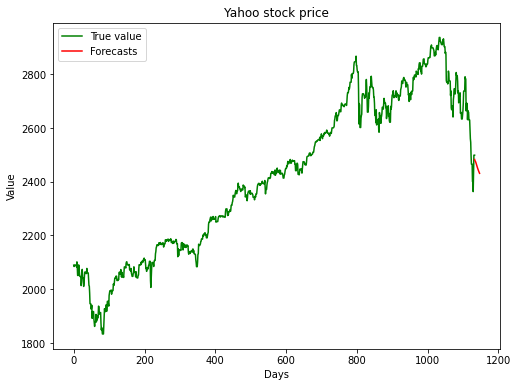

Epoch 1/100
51/51 [==============================] - 4s 25ms/step - loss: 0.3156 - mae: 0.3034 - rmse: 0.3155 - val_loss: 0.0189 - val_mae: 0.0179 - val_rmse: 0.0186
Epoch 2/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1540 - mae: 0.1415 - rmse: 0.1540 - val_loss: 0.0300 - val_mae: 0.0257 - val_rmse: 0.0303
Epoch 3/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1393 - mae: 0.1269 - rmse: 0.1393 - val_loss: 0.0558 - val_mae: 0.0500 - val_rmse: 0.0561
Epoch 4/100
51/51 [==============================] - 0s 10ms/step - loss: 0.1533 - mae: 0.1407 - rmse: 0.1533 - val_loss: 0.0635 - val_mae: 0.0628 - val_rmse: 0.0638
Epoch 5/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1385 - mae: 0.1267 - rmse: 0.1385 - val_loss: 0.0662 - val_mae: 0.0657 - val_rmse: 0.0665

Epoch 00005: val_loss improved from inf to 0.06619, saving model to my_model_5_0.066.h5
Epoch 6/100
51/51 [==============================] - 1s 10ms/step - loss: 0.1352 - m

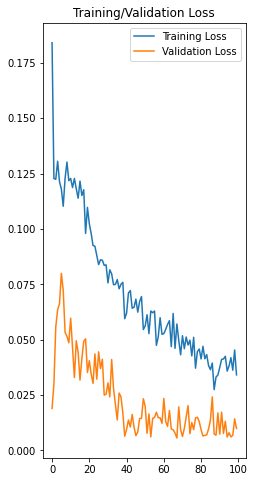

Epoch 1/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0297 - mae: 0.0257 - rmse: 0.0297 - val_loss: 0.0126 - val_mae: 0.0108 - val_rmse: 0.0138
Epoch 2/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0366 - mae: 0.0332 - rmse: 0.0366 - val_loss: 0.0480 - val_mae: 0.0465 - val_rmse: 0.0505
Epoch 3/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0389 - mae: 0.0348 - rmse: 0.0388 - val_loss: 0.0142 - val_mae: 0.0116 - val_rmse: 0.0159
Epoch 4/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0339 - mae: 0.0303 - rmse: 0.0338 - val_loss: 0.0196 - val_mae: 0.0174 - val_rmse: 0.0218
Epoch 5/100
102/102 [==============================] - 1s 9ms/step - loss: 0.0385 - mae: 0.0345 - rmse: 0.0384 - val_loss: 0.0195 - val_mae: 0.0181 - val_rmse: 0.0192

Epoch 00005: val_loss did not improve from 0.00602
Epoch 6/100
102/102 [==============================] - 1s 10ms/step - loss: 0.0339 - mae: 0.0306 - rmse: 0.0339 

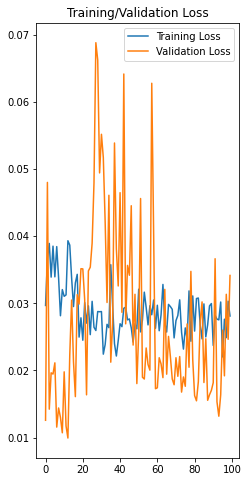

Epoch 1/100
152/152 [==============================] - 3s 8ms/step - loss: 0.0375 - mae: 0.0319 - rmse: 0.0375 - val_loss: 0.0811 - val_mae: 0.0749 - val_rmse: 0.0815
Epoch 2/100
152/152 [==============================] - 1s 7ms/step - loss: 0.0327 - mae: 0.0277 - rmse: 0.0327 - val_loss: 0.0596 - val_mae: 0.0542 - val_rmse: 0.0598
Epoch 3/100
152/152 [==============================] - 1s 7ms/step - loss: 0.0302 - mae: 0.0256 - rmse: 0.0302 - val_loss: 0.0604 - val_mae: 0.0560 - val_rmse: 0.0602
Epoch 4/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0382 - mae: 0.0331 - rmse: 0.0382 - val_loss: 0.0511 - val_mae: 0.0456 - val_rmse: 0.0515
Epoch 5/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0381 - mae: 0.0334 - rmse: 0.0381 - val_loss: 0.0604 - val_mae: 0.0541 - val_rmse: 0.0610

Epoch 00005: val_loss did not improve from 0.00602
Epoch 6/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0316 - mae: 0.0273 - rmse: 0.0316 - 

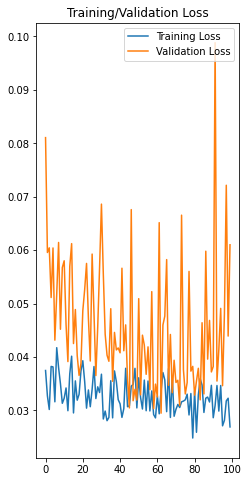

[array([[2502.7278, 2502.717 ]], dtype=float32), array([[2505.4841, 2505.4705]], dtype=float32), array([[2508.5024, 2508.4866]], dtype=float32), array([[2510.7773, 2510.7607]], dtype=float32), array([[2512.0647, 2512.0483]], dtype=float32), array([[2512.7834, 2512.7668]], dtype=float32), array([[2513.388 , 2513.3713]], dtype=float32), array([[2513.9587, 2513.9421]], dtype=float32), array([[2514.548 , 2514.5312]], dtype=float32), array([[2515.1543, 2515.1375]], dtype=float32), array([[2515.7559, 2515.7388]], dtype=float32), array([[2516.3354, 2516.3184]], dtype=float32), array([[2516.8855, 2516.8684]], dtype=float32), array([[2517.4075, 2517.3904]], dtype=float32), array([[2517.9038, 2517.8867]], dtype=float32)]
[2502.7278, 2505.4841, 2508.5024, 2510.7773, 2512.0647, 2512.7834, 2513.388, 2513.9587, 2514.548, 2515.1543, 2515.7559, 2516.3354, 2516.8855, 2517.4075, 2517.9038]


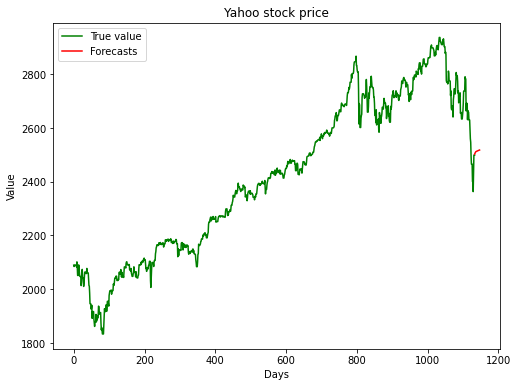

Epoch 1/60
51/51 [==============================] - 5s 27ms/step - loss: 0.2946 - mae: 0.2825 - rmse: 0.2945 - val_loss: 0.0144 - val_mae: 0.0124 - val_rmse: 0.0141
Epoch 2/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1338 - mae: 0.1180 - rmse: 0.1337 - val_loss: 0.0144 - val_mae: 0.0125 - val_rmse: 0.0141
Epoch 3/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1791 - mae: 0.1684 - rmse: 0.1790 - val_loss: 0.0688 - val_mae: 0.0672 - val_rmse: 0.0691
Epoch 4/60
51/51 [==============================] - 1s 10ms/step - loss: 0.1352 - mae: 0.1230 - rmse: 0.1352 - val_loss: 0.0674 - val_mae: 0.0672 - val_rmse: 0.0678
Epoch 5/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1406 - mae: 0.1278 - rmse: 0.1406 - val_loss: 0.0828 - val_mae: 0.0826 - val_rmse: 0.0832

Epoch 00005: val_loss improved from inf to 0.08284, saving model to my_model_5_0.083.h5
Epoch 6/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1333 - mae:

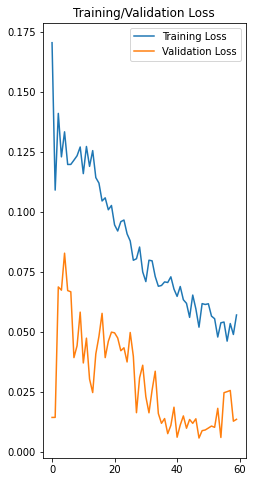

Epoch 1/60
102/102 [==============================] - 1s 11ms/step - loss: 0.0361 - mae: 0.0310 - rmse: 0.0358 - val_loss: 0.0277 - val_mae: 0.0255 - val_rmse: 0.0272
Epoch 2/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0472 - mae: 0.0422 - rmse: 0.0471 - val_loss: 0.0265 - val_mae: 0.0243 - val_rmse: 0.0251
Epoch 3/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0442 - mae: 0.0395 - rmse: 0.0439 - val_loss: 0.0237 - val_mae: 0.0216 - val_rmse: 0.0257
Epoch 4/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0388 - mae: 0.0346 - rmse: 0.0387 - val_loss: 0.0297 - val_mae: 0.0277 - val_rmse: 0.0323
Epoch 5/60
102/102 [==============================] - 1s 11ms/step - loss: 0.0371 - mae: 0.0323 - rmse: 0.0372 - val_loss: 0.0204 - val_mae: 0.0189 - val_rmse: 0.0200

Epoch 00005: val_loss did not improve from 0.00604
Epoch 6/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0405 - mae: 0.0361 - rmse: 0.0402 - 

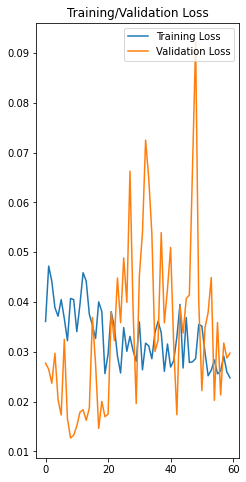

Epoch 1/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0420 - mae: 0.0371 - rmse: 0.0420 - val_loss: 0.0471 - val_mae: 0.0428 - val_rmse: 0.0474
Epoch 2/60
152/152 [==============================] - 1s 10ms/step - loss: 0.0396 - mae: 0.0343 - rmse: 0.0396 - val_loss: 0.0528 - val_mae: 0.0471 - val_rmse: 0.0532
Epoch 3/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0325 - mae: 0.0279 - rmse: 0.0325 - val_loss: 0.0500 - val_mae: 0.0455 - val_rmse: 0.0498
Epoch 4/60
152/152 [==============================] - 1s 10ms/step - loss: 0.0434 - mae: 0.0389 - rmse: 0.0434 - val_loss: 0.0409 - val_mae: 0.0364 - val_rmse: 0.0412
Epoch 5/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0309 - mae: 0.0264 - rmse: 0.0310 - val_loss: 0.0873 - val_mae: 0.0829 - val_rmse: 0.0867

Epoch 00005: val_loss did not improve from 0.00604
Epoch 6/60
152/152 [==============================] - 1s 10ms/step - loss: 0.0444 - mae: 0.0404 - rmse: 0.0444 - 

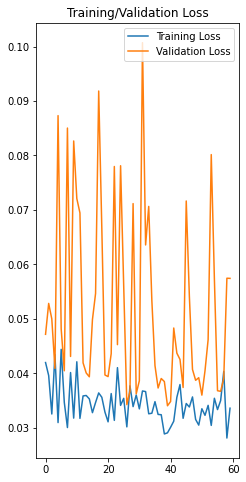

[array([[2485.7563, 2485.8423]], dtype=float32), array([[2481.326, 2481.386]], dtype=float32), array([[2481.3499, 2481.402 ]], dtype=float32), array([[2481.303 , 2481.3513]], dtype=float32), array([[2479.9731, 2480.022 ]], dtype=float32), array([[2478.1582, 2478.2085]], dtype=float32), array([[2476.1284, 2476.18  ]], dtype=float32), array([[2474.0342, 2474.086 ]], dtype=float32), array([[2471.9807, 2472.0332]], dtype=float32), array([[2470.0745, 2470.1272]], dtype=float32), array([[2468.3105, 2468.3638]], dtype=float32), array([[2466.6614, 2466.7146]], dtype=float32), array([[2465.104 , 2465.1575]], dtype=float32), array([[2463.6196, 2463.673 ]], dtype=float32), array([[2462.2002, 2462.2537]], dtype=float32)]
[2485.7563, 2481.326, 2481.3499, 2481.303, 2479.9731, 2478.1582, 2476.1284, 2474.0342, 2471.9807, 2470.0745, 2468.3105, 2466.6614, 2465.104, 2463.6196, 2462.2002]


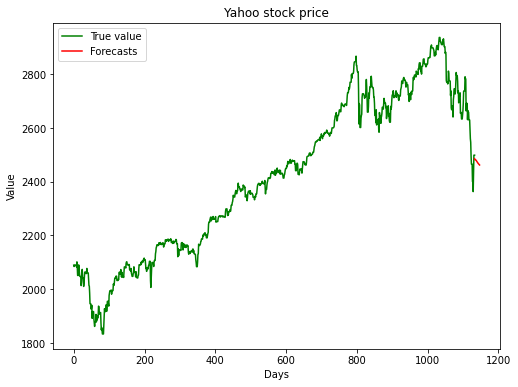

Epoch 1/90
51/51 [==============================] - 5s 27ms/step - loss: 0.2470 - mae: 0.2354 - rmse: 0.2469 - val_loss: 0.0154 - val_mae: 0.0131 - val_rmse: 0.0151
Epoch 2/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1105 - mae: 0.0966 - rmse: 0.1104 - val_loss: 0.0199 - val_mae: 0.0187 - val_rmse: 0.0195
Epoch 3/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1497 - mae: 0.1390 - rmse: 0.1497 - val_loss: 0.0380 - val_mae: 0.0334 - val_rmse: 0.0383
Epoch 4/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1607 - mae: 0.1495 - rmse: 0.1607 - val_loss: 0.0654 - val_mae: 0.0635 - val_rmse: 0.0657
Epoch 5/90
51/51 [==============================] - 1s 12ms/step - loss: 0.1391 - mae: 0.1275 - rmse: 0.1391 - val_loss: 0.0845 - val_mae: 0.0842 - val_rmse: 0.0848

Epoch 00005: val_loss improved from inf to 0.08447, saving model to my_model_5_0.084.h5
Epoch 6/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1272 - mae:

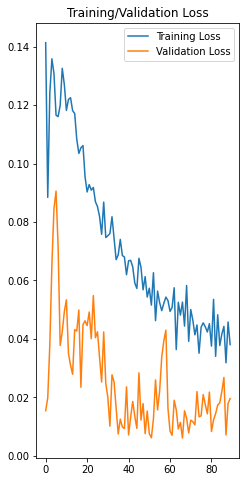

Epoch 1/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0354 - mae: 0.0310 - rmse: 0.0354 - val_loss: 0.0356 - val_mae: 0.0339 - val_rmse: 0.0390
Epoch 2/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0426 - mae: 0.0385 - rmse: 0.0423 - val_loss: 0.0281 - val_mae: 0.0259 - val_rmse: 0.0308
Epoch 3/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0481 - mae: 0.0439 - rmse: 0.0478 - val_loss: 0.0181 - val_mae: 0.0160 - val_rmse: 0.0204
Epoch 4/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0401 - mae: 0.0364 - rmse: 0.0401 - val_loss: 0.0164 - val_mae: 0.0147 - val_rmse: 0.0181
Epoch 5/90
102/102 [==============================] - 1s 10ms/step - loss: 0.0278 - mae: 0.0242 - rmse: 0.0277 - val_loss: 0.0510 - val_mae: 0.0499 - val_rmse: 0.0542

Epoch 00005: val_loss did not improve from 0.00782
Epoch 6/90
102/102 [==============================] - 1s 10ms/step - loss: 0.0304 - mae: 0.0269 - rmse: 0.0303 - 

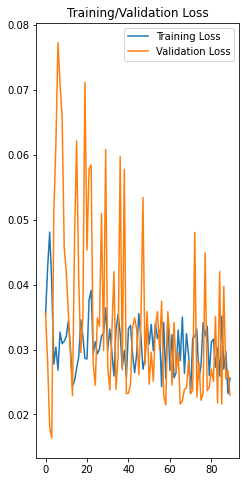

Epoch 1/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0425 - mae: 0.0374 - rmse: 0.0425 - val_loss: 0.0738 - val_mae: 0.0688 - val_rmse: 0.0734
Epoch 2/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0351 - mae: 0.0300 - rmse: 0.0351 - val_loss: 0.0652 - val_mae: 0.0610 - val_rmse: 0.0649
Epoch 3/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0388 - mae: 0.0339 - rmse: 0.0389 - val_loss: 0.0645 - val_mae: 0.0601 - val_rmse: 0.0642
Epoch 4/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0397 - mae: 0.0352 - rmse: 0.0397 - val_loss: 0.1032 - val_mae: 0.0973 - val_rmse: 0.1025
Epoch 5/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0387 - mae: 0.0342 - rmse: 0.0388 - val_loss: 0.0619 - val_mae: 0.0572 - val_rmse: 0.0617

Epoch 00005: val_loss did not improve from 0.00782
Epoch 6/90
152/152 [==============================] - 2s 10ms/step - loss: 0.0337 - mae: 0.0291 - rmse: 0.0337 - 

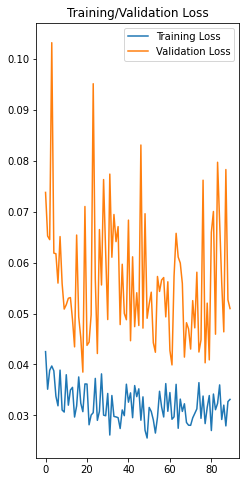

[array([[2483.4055, 2483.4365]], dtype=float32), array([[2478.987, 2479.016]], dtype=float32), array([[2478.9775, 2479.0046]], dtype=float32), array([[2479.124 , 2479.1504]], dtype=float32), array([[2477.9915, 2478.0166]], dtype=float32), array([[2476.0874, 2476.1125]], dtype=float32), array([[2473.8958, 2473.921 ]], dtype=float32), array([[2471.659, 2471.684]], dtype=float32), array([[2469.5066, 2469.532 ]], dtype=float32), array([[2467.546 , 2467.5718]], dtype=float32), array([[2465.7556, 2465.7817]], dtype=float32), array([[2464.092 , 2464.1184]], dtype=float32), array([[2462.5251, 2462.5515]], dtype=float32), array([[2461.0356, 2461.0625]], dtype=float32), array([[2459.6194, 2459.6465]], dtype=float32)]
[2483.4055, 2478.987, 2478.9775, 2479.124, 2477.9915, 2476.0874, 2473.8958, 2471.659, 2469.5066, 2467.546, 2465.7556, 2464.092, 2462.5251, 2461.0356, 2459.6194]


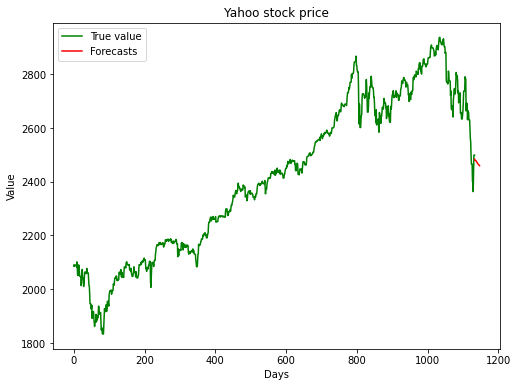

Epoch 1/120
51/51 [==============================] - 5s 28ms/step - loss: 0.3335 - mae: 0.3215 - rmse: 0.3334 - val_loss: 0.0224 - val_mae: 0.0216 - val_rmse: 0.0221
Epoch 2/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1571 - mae: 0.1412 - rmse: 0.1570 - val_loss: 0.0117 - val_mae: 0.0100 - val_rmse: 0.0116
Epoch 3/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1836 - mae: 0.1710 - rmse: 0.1836 - val_loss: 0.0607 - val_mae: 0.0525 - val_rmse: 0.0609
Epoch 4/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1504 - mae: 0.1351 - rmse: 0.1504 - val_loss: 0.0675 - val_mae: 0.0653 - val_rmse: 0.0678
Epoch 5/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1593 - mae: 0.1466 - rmse: 0.1593 - val_loss: 0.0928 - val_mae: 0.0926 - val_rmse: 0.0931

Epoch 00005: val_loss improved from inf to 0.09277, saving model to my_model_5_0.093.h5
Epoch 6/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1282 

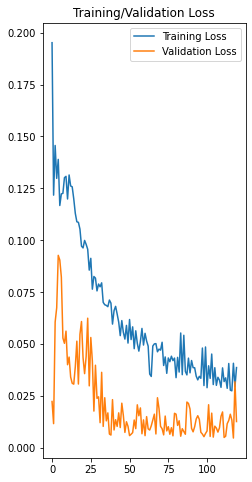

Epoch 1/120
102/102 [==============================] - 1s 12ms/step - loss: 0.0224 - mae: 0.0191 - rmse: 0.0228 - val_loss: 0.0373 - val_mae: 0.0358 - val_rmse: 0.0406
Epoch 2/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0254 - mae: 0.0219 - rmse: 0.0256 - val_loss: 0.0490 - val_mae: 0.0480 - val_rmse: 0.0525
Epoch 3/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0333 - mae: 0.0296 - rmse: 0.0332 - val_loss: 0.0348 - val_mae: 0.0335 - val_rmse: 0.0384
Epoch 4/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0262 - mae: 0.0227 - rmse: 0.0265 - val_loss: 0.0632 - val_mae: 0.0626 - val_rmse: 0.0673
Epoch 5/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0368 - mae: 0.0331 - rmse: 0.0367 - val_loss: 0.0214 - val_mae: 0.0200 - val_rmse: 0.0217

Epoch 00005: val_loss did not improve from 0.00525
Epoch 6/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0351 - mae: 0.0318 - rmse: 0.0

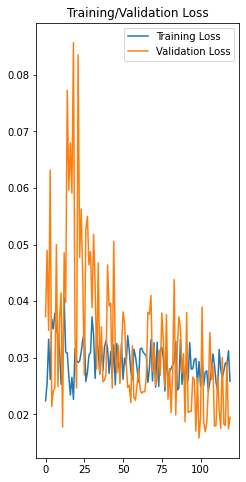

Epoch 1/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0389 - mae: 0.0337 - rmse: 0.0390 - val_loss: 0.0655 - val_mae: 0.0597 - val_rmse: 0.0654
Epoch 2/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0334 - mae: 0.0285 - rmse: 0.0334 - val_loss: 0.0914 - val_mae: 0.0871 - val_rmse: 0.0907
Epoch 3/120
152/152 [==============================] - 2s 10ms/step - loss: 0.0391 - mae: 0.0342 - rmse: 0.0392 - val_loss: 0.0649 - val_mae: 0.0592 - val_rmse: 0.0649
Epoch 4/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0360 - mae: 0.0311 - rmse: 0.0361 - val_loss: 0.0890 - val_mae: 0.0843 - val_rmse: 0.0883
Epoch 5/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0349 - mae: 0.0298 - rmse: 0.0350 - val_loss: 0.0844 - val_mae: 0.0797 - val_rmse: 0.0837

Epoch 00005: val_loss did not improve from 0.00525
Epoch 6/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0350 - mae: 0.0306 - rmse: 0.0

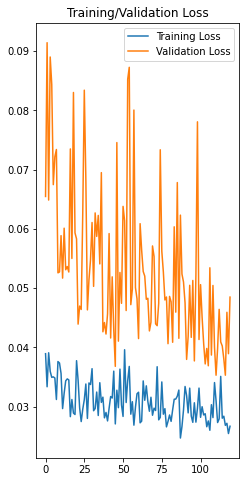

[array([[2483.34  , 2483.3384]], dtype=float32), array([[2476.2773, 2476.2751]], dtype=float32), array([[2475.235 , 2475.2332]], dtype=float32), array([[2474.2776, 2474.2761]], dtype=float32), array([[2472.348 , 2472.3462]], dtype=float32), array([[2469.9036, 2469.902 ]], dtype=float32), array([[2467.1868, 2467.185 ]], dtype=float32), array([[2464.5315, 2464.5295]], dtype=float32), array([[2461.9927, 2461.991 ]], dtype=float32), array([[2459.6343, 2459.6326]], dtype=float32), array([[2457.466, 2457.464]], dtype=float32), array([[2455.4585, 2455.4565]], dtype=float32), array([[2453.5898, 2453.5881]], dtype=float32), array([[2451.843, 2451.841]], dtype=float32), array([[2450.2083, 2450.2063]], dtype=float32)]
[2483.34, 2476.2773, 2475.235, 2474.2776, 2472.348, 2469.9036, 2467.1868, 2464.5315, 2461.9927, 2459.6343, 2457.466, 2455.4585, 2453.5898, 2451.843, 2450.2083]


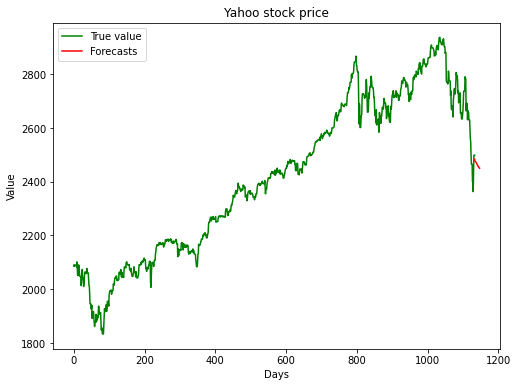

Epoch 1/50
32/32 [==============================] - 4s 40ms/step - loss: 0.3843 - mae: 0.3694 - rmse: 0.3842 - val_loss: 0.0487 - val_mae: 0.0383 - val_rmse: 0.0487
Epoch 2/50
32/32 [==============================] - 0s 14ms/step - loss: 0.1352 - mae: 0.1165 - rmse: 0.1351 - val_loss: 0.0296 - val_mae: 0.0281 - val_rmse: 0.0296
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1326 - mae: 0.1145 - rmse: 0.1325 - val_loss: 0.0221 - val_mae: 0.0187 - val_rmse: 0.0222
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1412 - mae: 0.1289 - rmse: 0.1412 - val_loss: 0.0164 - val_mae: 0.0135 - val_rmse: 0.0166
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1469 - mae: 0.1336 - rmse: 0.1468 - val_loss: 0.0173 - val_mae: 0.0145 - val_rmse: 0.0177

Epoch 00005: val_loss improved from inf to 0.01734, saving model to my_model_5_0.017.h5
Epoch 6/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1685 - mae:

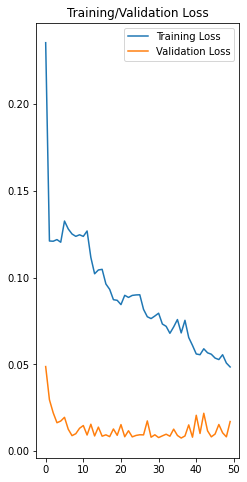

Epoch 1/50
64/64 [==============================] - 2s 26ms/step - loss: 0.0386 - mae: 0.0326 - rmse: 0.0384 - val_loss: 0.0148 - val_mae: 0.0120 - val_rmse: 0.0148
Epoch 2/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0402 - mae: 0.0343 - rmse: 0.0400 - val_loss: 0.0164 - val_mae: 0.0135 - val_rmse: 0.0164
Epoch 3/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0389 - mae: 0.0326 - rmse: 0.0386 - val_loss: 0.0236 - val_mae: 0.0204 - val_rmse: 0.0236
Epoch 4/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0318 - mae: 0.0263 - rmse: 0.0316 - val_loss: 0.0563 - val_mae: 0.0535 - val_rmse: 0.0563
Epoch 5/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0370 - mae: 0.0317 - rmse: 0.0368 - val_loss: 0.0192 - val_mae: 0.0165 - val_rmse: 0.0192

Epoch 00005: val_loss did not improve from 0.00805
Epoch 6/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0356 - mae: 0.0306 - rmse: 0.0354 - val_loss: 0.

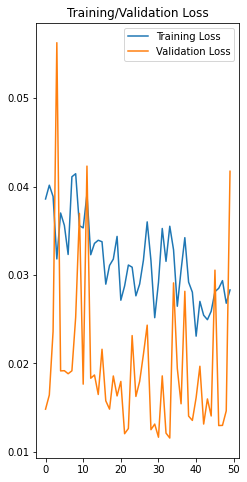

Epoch 1/50
95/95 [==============================] - 1s 14ms/step - loss: 0.0370 - mae: 0.0324 - rmse: 0.0370 - val_loss: 0.0695 - val_mae: 0.0629 - val_rmse: 0.0707
Epoch 2/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0336 - mae: 0.0287 - rmse: 0.0337 - val_loss: 0.0333 - val_mae: 0.0278 - val_rmse: 0.0342
Epoch 3/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0293 - mae: 0.0245 - rmse: 0.0294 - val_loss: 0.0521 - val_mae: 0.0472 - val_rmse: 0.0511
Epoch 4/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0262 - mae: 0.0215 - rmse: 0.0263 - val_loss: 0.0446 - val_mae: 0.0377 - val_rmse: 0.0455
Epoch 5/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0308 - mae: 0.0259 - rmse: 0.0309 - val_loss: 0.0391 - val_mae: 0.0334 - val_rmse: 0.0389

Epoch 00005: val_loss did not improve from 0.00805
Epoch 6/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0293 - mae: 0.0247 - rmse: 0.0294 - val_loss: 0.

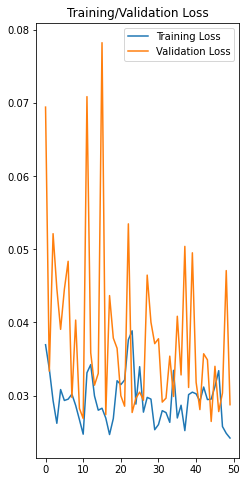

[array([[2479.296 , 2479.5183]], dtype=float32), array([[2472.5884, 2472.6797]], dtype=float32), array([[2469.8113, 2469.8525]], dtype=float32), array([[2466.5227, 2466.538 ]], dtype=float32), array([[2463.738 , 2463.7385]], dtype=float32), array([[2461.2012, 2461.1958]], dtype=float32), array([[2458.4731, 2458.4585]], dtype=float32), array([[2455.8965, 2455.8823]], dtype=float32), array([[2453.402 , 2453.3936]], dtype=float32), array([[2450.9458, 2450.941 ]], dtype=float32), array([[2448.5583, 2448.557 ]], dtype=float32), array([[2446.259, 2446.259]], dtype=float32), array([[2444.079 , 2444.0803]], dtype=float32), array([[2442.015, 2442.017]], dtype=float32), array([[2440.0535, 2440.0574]], dtype=float32)]
[2479.296, 2472.5884, 2469.8113, 2466.5227, 2463.738, 2461.2012, 2458.4731, 2455.8965, 2453.402, 2450.9458, 2448.5583, 2446.259, 2444.079, 2442.015, 2440.0535]


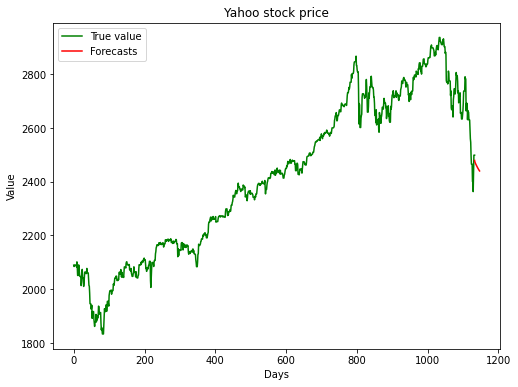

Epoch 1/90
32/32 [==============================] - 4s 40ms/step - loss: 0.3977 - mae: 0.3841 - rmse: 0.3976 - val_loss: 0.0187 - val_mae: 0.0161 - val_rmse: 0.0189
Epoch 2/90
32/32 [==============================] - 1s 16ms/step - loss: 0.1382 - mae: 0.1185 - rmse: 0.1381 - val_loss: 0.0224 - val_mae: 0.0191 - val_rmse: 0.0225
Epoch 3/90
32/32 [==============================] - 0s 14ms/step - loss: 0.1402 - mae: 0.1233 - rmse: 0.1402 - val_loss: 0.0106 - val_mae: 0.0097 - val_rmse: 0.0111
Epoch 4/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1480 - mae: 0.1331 - rmse: 0.1480 - val_loss: 0.0109 - val_mae: 0.0090 - val_rmse: 0.0117
Epoch 5/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1561 - mae: 0.1435 - rmse: 0.1561 - val_loss: 0.0110 - val_mae: 0.0090 - val_rmse: 0.0118

Epoch 00005: val_loss improved from inf to 0.01101, saving model to my_model_5_0.011.h5
Epoch 6/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1828 - mae:

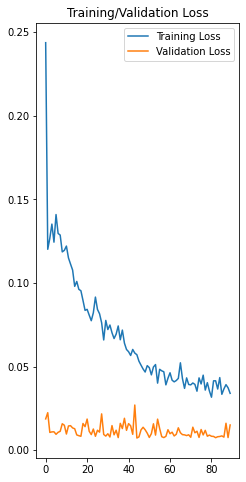

Epoch 1/90
64/64 [==============================] - 2s 26ms/step - loss: 0.0263 - mae: 0.0215 - rmse: 0.0263 - val_loss: 0.0167 - val_mae: 0.0147 - val_rmse: 0.0167
Epoch 2/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0268 - mae: 0.0224 - rmse: 0.0267 - val_loss: 0.0314 - val_mae: 0.0300 - val_rmse: 0.0314
Epoch 3/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0370 - mae: 0.0326 - rmse: 0.0368 - val_loss: 0.0109 - val_mae: 0.0087 - val_rmse: 0.0109
Epoch 4/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0317 - mae: 0.0274 - rmse: 0.0314 - val_loss: 0.0176 - val_mae: 0.0158 - val_rmse: 0.0176
Epoch 5/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0382 - mae: 0.0333 - rmse: 0.0379 - val_loss: 0.0146 - val_mae: 0.0118 - val_rmse: 0.0146

Epoch 00005: val_loss did not improve from 0.00727
Epoch 6/90
64/64 [==============================] - 1s 13ms/step - loss: 0.0269 - mae: 0.0225 - rmse: 0.0269 - val_loss: 0.

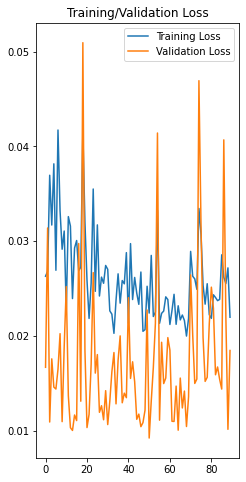

Epoch 1/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0295 - mae: 0.0243 - rmse: 0.0297 - val_loss: 0.0449 - val_mae: 0.0396 - val_rmse: 0.0442
Epoch 2/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0302 - mae: 0.0252 - rmse: 0.0303 - val_loss: 0.0499 - val_mae: 0.0451 - val_rmse: 0.0489
Epoch 3/90
95/95 [==============================] - 1s 13ms/step - loss: 0.0320 - mae: 0.0269 - rmse: 0.0321 - val_loss: 0.0478 - val_mae: 0.0433 - val_rmse: 0.0468
Epoch 4/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0290 - mae: 0.0241 - rmse: 0.0291 - val_loss: 0.0403 - val_mae: 0.0356 - val_rmse: 0.0401
Epoch 5/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0327 - mae: 0.0278 - rmse: 0.0327 - val_loss: 0.0437 - val_mae: 0.0388 - val_rmse: 0.0430

Epoch 00005: val_loss did not improve from 0.00727
Epoch 6/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0265 - mae: 0.0218 - rmse: 0.0266 - val_loss: 0.

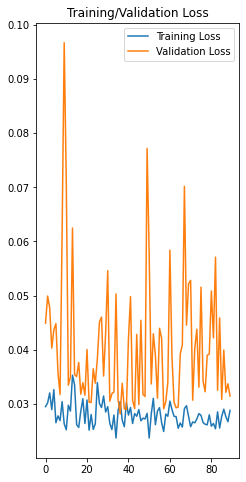

[array([[2495.0105, 2494.7605]], dtype=float32), array([[2496.324 , 2496.0986]], dtype=float32), array([[2498.6025, 2498.385 ]], dtype=float32), array([[2500.768 , 2500.5522]], dtype=float32), array([[2503.0066, 2502.7896]], dtype=float32), array([[2505.0972, 2504.879 ]], dtype=float32), array([[2506.7898, 2506.57  ]], dtype=float32), array([[2508.3174, 2508.0962]], dtype=float32), array([[2509.6956, 2509.4744]], dtype=float32), array([[2510.9827, 2510.7622]], dtype=float32), array([[2512.2258, 2512.0056]], dtype=float32), array([[2513.434, 2513.214]], dtype=float32), array([[2514.6   , 2514.3804]], dtype=float32), array([[2515.7178, 2515.4985]], dtype=float32), array([[2516.783 , 2516.5645]], dtype=float32)]
[2495.0105, 2496.324, 2498.6025, 2500.768, 2503.0066, 2505.0972, 2506.7898, 2508.3174, 2509.6956, 2510.9827, 2512.2258, 2513.434, 2514.6, 2515.7178, 2516.783]


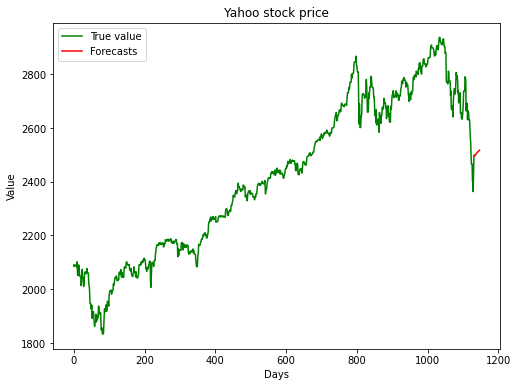

Epoch 1/120
32/32 [==============================] - 4s 42ms/step - loss: 0.3938 - mae: 0.3801 - rmse: 0.3937 - val_loss: 0.0237 - val_mae: 0.0193 - val_rmse: 0.0238
Epoch 2/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1344 - mae: 0.1133 - rmse: 0.1344 - val_loss: 0.0284 - val_mae: 0.0237 - val_rmse: 0.0284
Epoch 3/120
32/32 [==============================] - 1s 17ms/step - loss: 0.1473 - mae: 0.1299 - rmse: 0.1473 - val_loss: 0.0139 - val_mae: 0.0114 - val_rmse: 0.0143
Epoch 4/120
32/32 [==============================] - 0s 14ms/step - loss: 0.1543 - mae: 0.1358 - rmse: 0.1543 - val_loss: 0.0255 - val_mae: 0.0231 - val_rmse: 0.0259
Epoch 5/120
32/32 [==============================] - 1s 17ms/step - loss: 0.1702 - mae: 0.1527 - rmse: 0.1701 - val_loss: 0.0122 - val_mae: 0.0102 - val_rmse: 0.0128

Epoch 00005: val_loss improved from inf to 0.01221, saving model to my_model_5_0.012.h5
Epoch 6/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1774 

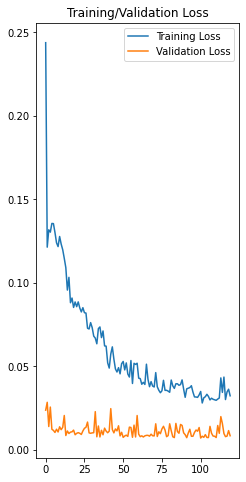

Epoch 1/120
64/64 [==============================] - 2s 26ms/step - loss: 0.0233 - mae: 0.0192 - rmse: 0.0233 - val_loss: 0.0214 - val_mae: 0.0190 - val_rmse: 0.0214
Epoch 2/120
64/64 [==============================] - 1s 15ms/step - loss: 0.0227 - mae: 0.0187 - rmse: 0.0228 - val_loss: 0.0235 - val_mae: 0.0221 - val_rmse: 0.0235
Epoch 3/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0237 - mae: 0.0197 - rmse: 0.0236 - val_loss: 0.0243 - val_mae: 0.0229 - val_rmse: 0.0243
Epoch 4/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0308 - mae: 0.0268 - rmse: 0.0306 - val_loss: 0.0161 - val_mae: 0.0144 - val_rmse: 0.0161
Epoch 5/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0399 - mae: 0.0357 - rmse: 0.0397 - val_loss: 0.0247 - val_mae: 0.0233 - val_rmse: 0.0247

Epoch 00005: val_loss did not improve from 0.00730
Epoch 6/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0324 - mae: 0.0283 - rmse: 0.0321 - val_lo

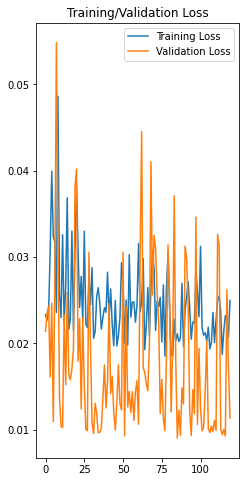

Epoch 1/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0290 - mae: 0.0243 - rmse: 0.0290 - val_loss: 0.0378 - val_mae: 0.0314 - val_rmse: 0.0385
Epoch 2/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0301 - mae: 0.0250 - rmse: 0.0301 - val_loss: 0.0331 - val_mae: 0.0275 - val_rmse: 0.0337
Epoch 3/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0295 - mae: 0.0243 - rmse: 0.0296 - val_loss: 0.0386 - val_mae: 0.0344 - val_rmse: 0.0381
Epoch 4/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0276 - mae: 0.0229 - rmse: 0.0276 - val_loss: 0.0531 - val_mae: 0.0486 - val_rmse: 0.0518
Epoch 5/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0301 - mae: 0.0252 - rmse: 0.0302 - val_loss: 0.0383 - val_mae: 0.0340 - val_rmse: 0.0379

Epoch 00005: val_loss did not improve from 0.00730
Epoch 6/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0364 - mae: 0.0313 - rmse: 0.0365 - val_lo

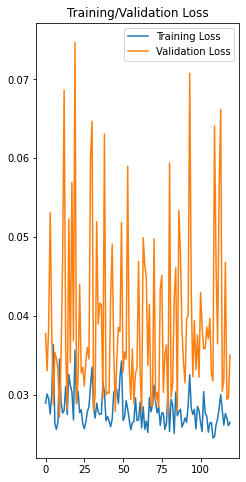

[array([[2473.4424, 2473.4353]], dtype=float32), array([[2464.4324, 2464.398 ]], dtype=float32), array([[2461.3567, 2461.3162]], dtype=float32), array([[2459.7551, 2459.7126]], dtype=float32), array([[2457.8965, 2457.8499]], dtype=float32), array([[2455.165 , 2455.1135]], dtype=float32), array([[2451.731 , 2451.6738]], dtype=float32), array([[2448.6323, 2448.574 ]], dtype=float32), array([[2445.9802, 2445.9233]], dtype=float32), array([[2443.574 , 2443.5188]], dtype=float32), array([[2441.3057, 2441.252 ]], dtype=float32), array([[2439.0967, 2439.0437]], dtype=float32), array([[2437.007, 2436.954]], dtype=float32), array([[2435.0706, 2435.0183]], dtype=float32), array([[2433.2864, 2433.2346]], dtype=float32)]
[2473.4424, 2464.4324, 2461.3567, 2459.7551, 2457.8965, 2455.165, 2451.731, 2448.6323, 2445.9802, 2443.574, 2441.3057, 2439.0967, 2437.007, 2435.0706, 2433.2864]


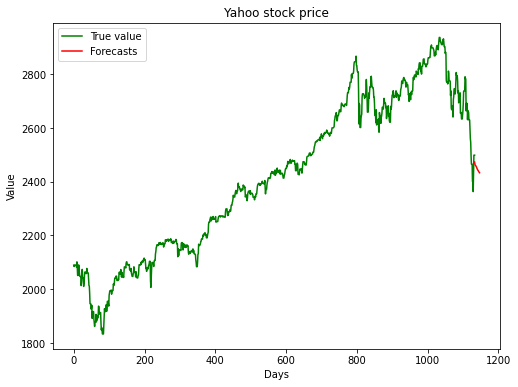

In [18]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [19]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [20]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.09117199194928009, 0.08326924840609233, 0.09098692461848258, 0.04777332941691081, 0.04440288481613001, 0.04801538002987702] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.05393720390896003, 0.048043736877540745, 0.05384878477702538, 0.034070007689297195, 0.03180653869484862, 0.03475301039715608] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.04409092139452695, 0.03899542250360052, 0.04405232957874735, 0.032014580278967815, 0.029757530017135048, 0.03273327502577255] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.051235233029971516, 0.04541217238745756, 0.05110704388676418, 0.038592445666694807, 0.036356207076460124, 0.03946942994629757] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.044768345245608576, 0.039603790813298144, 0.04474234562367201, 0.03882404467677353, 0.03651860

In [21]:
print(final_dict)

{1: [0.09117199194928009, 0.08326924840609233, 0.09098692461848258, 0.04777332941691081, 0.04440288481613001, 0.04801538002987702], 2: [0.05393720390896003, 0.048043736877540745, 0.05384878477702538, 0.034070007689297195, 0.03180653869484862, 0.03475301039715608], 3: [0.04409092139452695, 0.03899542250360052, 0.04405232957874735, 0.032014580278967815, 0.029757530017135048, 0.03273327502577255], 4: [0.051235233029971516, 0.04541217238745756, 0.05110704388676418, 0.038592445666694807, 0.036356207076460124, 0.03946942994629757], 5: [0.044768345245608576, 0.039603790813298144, 0.04474234562367201, 0.03882404467677353, 0.03651860386340155, 0.03950525317168622], 6: [0.04119077775006493, 0.036256933693463604, 0.041177808332981326, 0.035708607143412036, 0.0335172832730071, 0.03638892278411529], 7: [0.05037536376466353, 0.04347014705340068, 0.05020516473799944, 0.023519602647672097, 0.02041606449211637, 0.023808274026960136], 8: [0.04062322552695318, 0.034691432283984296, 0.040523270641764, 0.0

In [22]:
final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.091172,0.083269,0.090987,0.047773,0.044403,0.048015
2,0.053937,0.048044,0.053849,0.034070,0.031807,0.034753
3,0.044091,0.038995,0.044052,0.032015,0.029758,0.032733
4,0.051235,0.045412,0.051107,0.038592,0.036356,0.039469
5,0.044768,0.039604,0.044742,0.038824,0.036519,0.039505
6,0.041191,0.036257,0.041178,0.035709,0.033517,0.036389
7,0.050375,0.043470,0.050205,0.023520,0.020416,0.023808
8,0.040623,0.034691,0.040523,0.023159,0.020233,0.023415
9,0.037348,0.031711,0.037264,0.022848,0.019935,0.023229


In [23]:
final_df.to_csv(r"resultados.csv",index=True)